In [66]:
import os
import vtk
import numpy as np
from utilities import ReadVTPFile, GetCentroid, ReadVTKFile, WriteVTIFile, WriteVTPFile, ThresholdInBetween, ExtractSurface, LargestConnectedRegion
from vtk.util.numpy_support import vtk_to_numpy, numpy_to_vtk

In [17]:
InputFolder = "/Users/ana/Documents/AnahitaSeresti/05_PrePostCABG/ImagingData/SU24A-CCTA"
slice_base = "Slice_Base.vtp"
slice_apex = "Slice_Apex.vtp"
image_ = "SU24A_CCTA_Registered.vtk"
point_base = GetCentroid(ReadVTPFile(os.path.join(InputFolder,slice_base)))
point_apex = GetCentroid(ReadVTPFile(os.path.join(InputFolder, slice_apex)))

In [18]:
CL_direction = [
    point_base[0] - point_apex[0],
    point_base[1] - point_apex[1],
    point_base[2] - point_apex[2]
                ]

CL_direction /= np.linalg.norm(CL_direction)
np.linalg.norm(CL_direction)

0.9999999999999999

In [19]:
z_axis = CL_direction
x_axis = [-z_axis[2], 0, z_axis[0]]
y_axis = np.cross(x_axis, z_axis)

In [20]:
center = [
    (point_base[0] + point_apex[0])/2,
    (point_base[1] + point_apex[1])/2,
    (point_base[2] + point_apex[2])/2
]
center

[4.022712448639073, -20.33479918729179, -22.4192670263446]

In [51]:
def SliceWPlane(Volume,Origin,Norm):
    plane=vtk.vtkPlane()
    plane.SetOrigin(Origin)
    plane.SetNormal(Norm)
    Slice=vtk.vtkCutter()
    Slice.GenerateTrianglesOff()
    Slice.SetCutFunction(plane)
    Slice.SetInputData(Volume)
    Slice.Update()
    
    return Slice.GetOutput()

In [53]:
image = ReadVTKFile(os.path.join(InputFolder, image_))
sample_slice = SliceWPlane(image, center, CL_direction)
WriteVTPFile(os.path.join(InputFolder, "sampleslice.vtp"), sample_slice)


In [ ]:
scalar_array_name = image.GetPointData().GetScalars().GetName()
BloodPool = ThresholdInBetween(sample_slice, scalar_array_name, 200, 700)
BloodPool = ExtractSurface(LargestConnectedRegion(BloodPool))

bp_centroid = GetCentroid(BloodPool)
properties = vtk.vtkMassProperties()
properties.SetInputData(BloodPool)
properties.Update()
area = properties.GetSurfaceArea()

radius = np.sqrt(area/np.pi)
print(area, radius)

0.8458787967500213 1.6408887333356308


In [86]:
from scipy.spatial.transform import Rotation as R
rotation, _ = R.align_vectors([[0, 0, 1]], [CL_direction])

def Rotate(slice, scalar_array_name):
    new_point_x = []
    new_point_y = []

    for i in range(slice.GetNumberOfPoints()):
        point_ = rotation.apply(slice.GetPoint(i))
        new_point_x.append(point_[0])
        new_point_y.append(point_[1])

    new_point_x = np.array(new_point_x)
    new_point_y = np.array(new_point_y)
    scalar_value = vtk_to_numpy(slice.GetPointData().GetArray(scalar_array_name))
    return new_point_x, new_point_y, scalar_value

/var/folders/05/bygg4rdj3n7543jkngl6k6z40000gn/T/ipykernel_15256/4141764151.py:2: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  rotation, _ = R.align_vectors([[0, 0, 1]], [CL_direction])


17.94047004208806 2.389692234824551


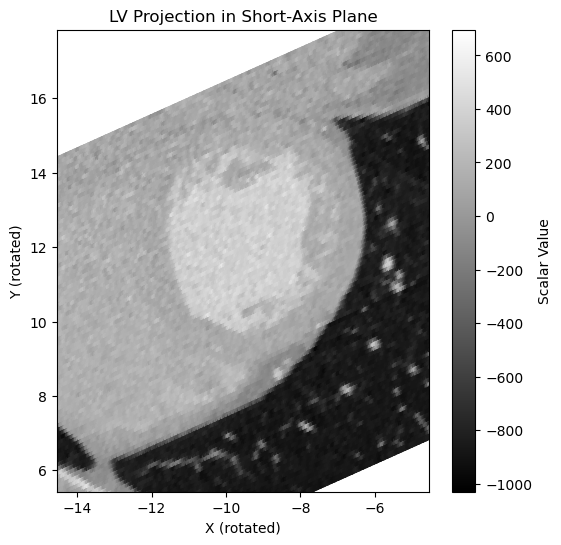

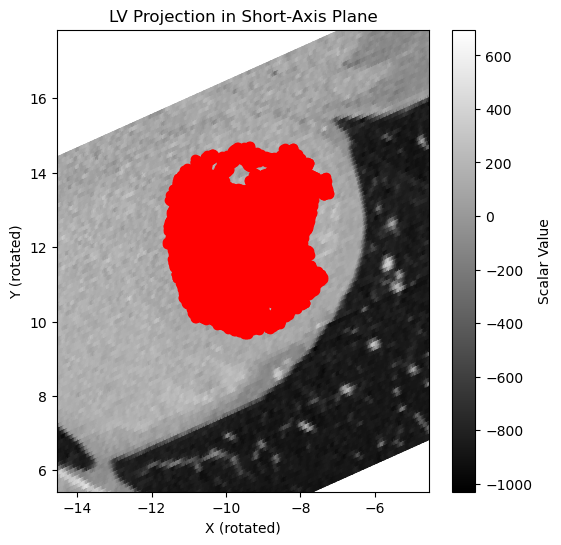

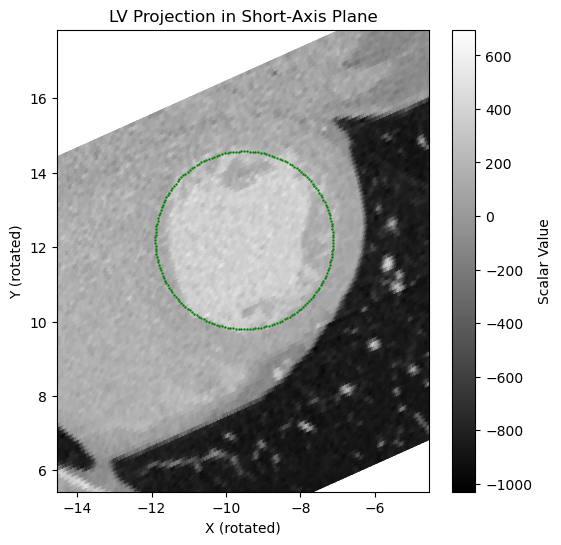

In [114]:
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull


center_rotated = rotation.apply(center)
centroid_rotated = rotation.apply(bp_centroid)


new_point_x, new_point_y, scalar_value = Rotate(sample_slice, scalar_array_name)
new_point_x_bp, new_point_y_bp, scalar_value_bp = Rotate(BloodPool, scalar_array_name)

coords_2d = np.column_stack((new_point_x_bp, new_point_y_bp))
hull = ConvexHull(coords_2d)
hull_area = hull.volume

radius = np.sqrt(hull_area/np.pi)
print(hull_area, radius)

plt.figure(figsize=(6, 6))
sc = plt.scatter(new_point_x, new_point_y, c=scalar_value, cmap='gray', s=10)
plt.colorbar(sc, label='Scalar Value')
plt.axis('equal')
plt.xlabel('X (rotated)')
plt.ylabel('Y (rotated)')
plt.xlim([center_rotated[0]-5, center_rotated[0]+5])
plt.ylim([center_rotated[1]-5, center_rotated[1]+5])
plt.title('LV Projection in Short-Axis Plane')
plt.show()


plt.figure(figsize=(6, 6))
sc = plt.scatter(new_point_x, new_point_y, c=scalar_value, cmap='gray', s=10)
plt.scatter(new_point_x_bp, new_point_y_bp, color='red')
plt.colorbar(sc, label='Scalar Value')
plt.axis('equal')
plt.xlabel('X (rotated)')
plt.ylabel('Y (rotated)')
plt.xlim([center_rotated[0]-5, center_rotated[0]+5])
plt.ylim([center_rotated[1]-5, center_rotated[1]+5])
plt.title('LV Projection in Short-Axis Plane')
plt.show()

x_circle = []
y_circle = []
for theta in np.arange(0,np.pi*2, np.pi/100):
    x_circle.append(centroid_rotated[0] + radius*np.cos(theta))
    y_circle.append(centroid_rotated[1] + radius*np.sin(theta))

plt.figure(figsize=(6, 6))
sc = plt.scatter(new_point_x, new_point_y, c=scalar_value, cmap='gray', s=10)
plt.scatter(x_circle, y_circle, color='green', s = 0.5)
plt.colorbar(sc, label='Scalar Value')
plt.axis('equal')
plt.xlabel('X (rotated)')
plt.ylabel('Y (rotated)')
plt.xlim([center_rotated[0]-5, center_rotated[0]+5])
plt.ylim([center_rotated[1]-5, center_rotated[1]+5])
plt.title('LV Projection in Short-Axis Plane')
plt.show()
